<div class="alert alert-block alert-danger">
<h1>AI4I 2020 Predictive Maintenance Dataset</h1>
</div>

https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset#

Data Set Information:

Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in industry to the best of our knowledge. 

<div class="alert alert-block alert-danger">
<h2>Table of Contents</h2>
</div>

[Functions to be used](#1.0)<br>
    <ul>
        <li>Pandas</li>
        <li>Visualizations</li>
        <li>Confusion matrix and metrics</li>
        <li>Encoding</li>
        <li>KBinsDiscretizer</li>
        <li>Scaler (Standard, MinMax)</li>
        <li>Missing value imputation</li>
    </ul>
[Import Libraries](#2.0)<br>
[Load Data](#3.0)<br>
[Exploratory Data Analysis (EDA)](#4.0)<br>
    <ul>
        <li>[Analyze each feature](#4.1)</li>
    </ul>
[Machine Learning Algorithms and Results](#5.0)<br>
    <ul>
        <li>[Feature engineering](#5.1)</li>
        <li>[Correlation of the features](#5.2)</li>
        <li>[Split Dataframe](#5.3)</li>
        <li>[Overcoming Class Imbalance using SMOTE](#5.4)</li>
        <li>[Building ML models](#5.5)</li>
            <ul>
                <li>Logistic Regression</li>
                <li>Random Forest</li>
                <li>Naive Bayes</li>
                <li>Support Vector</li>
                <li>k-Nearest Neighbours</li>
                <li>Stochastic Gradient Descent</li>
                <li>Gradient-Boosted Tree</li>
                <li>XGBClassifier</li>
            </ul>
        <li>[Model selection - final](#5.6)</li>
        <li>[Evaluation of the selected model](#5.7)</li>
            <ul>
                <li>ROC/AUC</li>
                <li>TPR/TNR - Threshold</li>
                <li>Precision(PPV)/NPV - Recall</li>
                <li>Accuracy - Threshold</li>
            </ul>
    </ul>

<a id='1.0'></a>
<div class="alert alert-block alert-danger">
<h2>Functions to be used</h2>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Pandas
    </h4>
</div>

In [1]:
def count_null_columns(df):
    df_null = pd.DataFrame(df.isnull().sum(), columns=['count'])
    df_null = df_null[df_null["count"] != 0]
    if len(df_null.index) > 0:
        return df_null[df_null['count']>0]
    else:
        print("There are no null values in the dataframe.")

In [2]:
def percentCol(df, col):
    df1 = df.groupby(col)[col].count().rename("count").reset_index().sort_values("count", ascending=False)
    df1["percentage (%)"] = 100*df1["count"] / df1["count"].sum()
    df1 = df1.round({"percentage (%)": 1})
#     df1 = df1.fillna('nan')
    df1.set_index(df1.columns[0], inplace=True)
    if len(df1) > 10:
        df1 = df1[:8]
        print("The first 8 items have been plotted.")
    return df1

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

def evaluate_model(model, X_train, y_train, X_test, y_test, params):
    cv = GridSearchCV(estimator=model, cv=10, scoring='accuracy', param_grid=params, 
#                        n_jobs=-1
                     ).fit(X_train, y_train)
    y_pred = cv.predict(X_test)
    y_pred_proba = cv.predict_proba(X_test)
    
    model_cm = confusion_matrix(y_test, y_pred)
    model_cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
    model_cm_metrics = confusion_matrix_func(model_cm, model_cm_norm)
    
    return model_cm_metrics, y_pred_proba

<div class="alert alert-block alert-success">
    <h4>
        Visualizations
    </h4>
</div>

In [4]:
# plot a stacked bar chart to show how a feature is categorized using the another feature
def stacked_bar_chart(df_target, target_col, col, figsize=(8,5)):
    
    df = df_target.groupby([target_col])[col].value_counts(dropna=False).to_frame()\
        .rename(columns={col: 'count'}).reset_index()\
        .pivot(index=target_col, columns=col, values='count').fillna(0)
    
    df["sum_each"] = df.iloc[:,0] + df.iloc[:,1]
    df.sort_values("sum_each", ascending=False, inplace=True)
    df.drop("sum_each", axis=1, inplace=True)

    if len(df) > 10:
        df = df.iloc[:8, :]
        print("The first 8 items have been plotted.")
    
    print(df)
    
    fig, ax = plt.subplots(figsize=figsize)
    width = 0.35
    
    cmap = matplotlib.cm.get_cmap("Set1").colors

    x = [str(i) for i in df.index]
    y = 0
    for i, col_group in enumerate(df.columns):
        try:
            ax.bar(x, df[col_group].values, width, bottom=y, color=cmap[i], label=df.columns[i], 
                   zorder=3)
        except:
            ax.bar(x, df[col_group].values, width, bottom=y, color=cmap(i), label=df.columns[i], 
                   zorder=3)
        y += df[col_group].values
    
    ax.set_xticklabels(x, rotation = 45)
    
    ax.set_xlabel(df.index.name)
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(axis='y', zorder=0, lw=0.2)
        
    plt.show()

In [5]:
def autopct(pct_max, pct, allvals):
    if pct<pct_max:
        return ""
    else:
        absolute = int(round(pct/100.*sum(allvals), 0))
        return "{p:.1f}% \n({val})".format(p=pct, val=absolute)

def pie_chart(df, explode=None, title=None, pct_max=5, legend_pos=(0.8, 0, 0.4, 1), 
              p_theta_max=15, p_theta_min=2):
#     df = df.toPandas().set_index(df.columns[0])
#     df.index.name = None
    items = df.index
    values = df.iloc[:, 0]
    percent = df.iloc[:, 1]
    
    fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))
    #################################################################
    textprops = dict(horizontalalignment="center", verticalalignment="center", rotation=0, 
                     rotation_mode="anchor", size=12, weight= "bold", color="white")
    wedgeprops=dict(edgecolor="black", linewidth=1)
    labels = [f"{i} ({j} - {k:1.1f}%)" for i,j,k in zip(items, values, percent)]
    #################################################################
    wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: autopct(pct_max, pct, values), 
                                      textprops=textprops, radius=1, startangle=0, counterclock=True, 
                                      pctdistance = 0.6, wedgeprops=wedgeprops, explode=explode)
    #################################################################
    #---------------------------------------------------------------#
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center", ha="center")

    values_2 = [f"{i:1.1f}% ({j})" for i,j in zip(percent, values)]

    for i, p in enumerate(wedges):
        if (p.theta2 - p.theta1 < p_theta_max) & (p.theta2 - p.theta1 > p_theta_min):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = "angle,angleA=0,angleB={}".format(ang)
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            plt.annotate(values_2[i], xy=(x, y), xytext=(1.6*np.sign(x), 1.5*y),
                        horizontalalignment=horizontalalignment, **kw)
    #---------------------------------------------------------------#
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax.set_title(title, size=16, weight="bold")

    plt.legend(labels=labels, fontsize=12, bbox_to_anchor=legend_pos)
        
    plt.show()

In [6]:
from scipy import stats

def histogram(df, target_col, figsize=(8,5)):
    fig, ax = plt.subplots(figsize=figsize)

#     age_vals = [i[0] for i in df.select(target_col).na.drop().collect()]
    age_vals = [i for i in df[target_col].dropna()]
    
    sigma = df[target_col].dropna().std() # standard deviation of distribution
    mean = df[target_col].dropna().mean() # mean of distribution
    median = np.median(age_vals)
    mode = stats.mode(age_vals)[0][0]   

    x = mean + sigma * np.random.randn(1000)

    # fig, axes = plt.subplots(1, 1, figsize=(16, 6))
    n, bins, patches = ax.hist(age_vals, 20, density=True, color='lightgreen', 
                                           stacked=True, alpha=0.75)

    # add mean, median and mode lines
    ax.axvline(mean, 0, 1, color='red', label='mean: {:.2f}'.format(mean))
    ax.axvline(median, 0, 1, color='blue', label='median: {:.2f}'.format(median))
    ax.axvline(mode, 0, 1, color='green', label='mode: {:.2f}'.format(mode))

    # add a 'best fit' line
    y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
        np.exp(-0.5 * (1 / sigma * (bins - mean))**2))
    ax.plot(bins, y, '--', color ='black')

    ax.grid(True)
    ax.set_ylabel('Probability')
    ax.set_title(f'{target_col} (sigma={round(sigma, 2)})')
    ax.legend()
    fig.tight_layout()
    fig.show()

<img src="https://miro.medium.com/max/1400/1*2c21SkzJMf3frPXPAR_gZA.png" style="height:250px">

median (Q2/50th Percentile): the middle value of the dataset<br>
first quartile (Q1/25th Percentile): the middle number between the smallest number (not the “minimum”) and the median of the dataset.<br>
third quartile (Q3/75th Percentile): the middle value between the median and the highest value (not the “maximum”) of the dataset.<br>
interquartile range (IQR): 25th to the 75th percentile.<br>
whiskers (shown in blue)<br>
outliers (shown as green circles)<br>
“maximum”: Q3 + 1.5*IQR<br>
“minimum”: Q1 -1.5*IQR<br>

In [7]:
# plot a boxplot to show how the values in the dataset are spread out
def box_plot(df, label):
    fig, ax = plt.subplots(figsize = (10, 1))
    # rectangular box plot
    bplot = ax.boxplot(df,
                           vert=False,  # vertical box alignment
                           notch=True,  # notch shape
                           patch_artist=True,  # fill with color
                           labels=[label]  # will be used to label x-ticks
                          )
    # fill with colors
    colors = ['pink', 'lightblue', 'lightgreen']
    for box in (bplot):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)


    whiskers_1 = bplot['whiskers'][0].get_xdata()[1]
    whiskers_2 = bplot['whiskers'][0].get_xdata()[0]
    median = bplot['medians'][0].get_xdata()[0]
    whiskers_3 = bplot['whiskers'][1].get_xdata()[0]
    whiskers_4 = bplot['whiskers'][1].get_xdata()[1]
    
    ax.text(whiskers_1, 1.15, f"{whiskers_1}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_2, 1.25, f"{whiskers_2}", ha='center', va='center', color='b', size=13)
    ax.text(median, 0.7, f"{median}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_3, 1.25, f"{whiskers_3}", ha='center', va='center', color='b', size=13)
    ax.text(whiskers_4, 1.15, f"{whiskers_4}", ha='center', va='center', color='b', size=13)

    ax.xaxis.grid(True)
    plt.show()

    outliers = bplot['fliers'][0].get_xdata()

In [8]:
def balanceOrInbalance(df_label):
    col = df_label.index.name
    uniqs = [str(i) for i in df_label.index]
    vals = [i for i in df_label["count"].values]
    
    fig, ax = plt.subplots(figsize = (12, 2))
    # Horizontal bar chart
    ax.barh(uniqs, vals, align='center', color=['red', 'green'])
    ax.text(vals[0]-vals[0]*0.1, 0, vals[0], ha='center', va='center', color='w', size=20)
    ax.text(vals[1]-vals[1]*0.2, 1, vals[1], ha='center', va='center', color='w', size=20)
    ax.set_ylabel(col)
    ax.set_title('Balance situation in the dependent feature')

    plt.show()

<div class="alert alert-block alert-success">
    <h4>
        Confusion matrix and metrics
    </h4>
</div>

In [9]:
import math

def TP_FP_TN_FN_func(cm, dataframe):
    
    TN, FP, FN, TP = cm.ravel()

    #____________ METRICS ____________#
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR = round(TN / (TN + FP), 2)

    # accuracy (ACC)
    ACC = round((TP + TN) / (TP + TN + FP + FN), 2)
    # balanced accuracy (BA)
    BA = round((TPR + TNR) / 2, 2)

    # Precision or positive predictive value
    PPV = round(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    NPV = round(TN / (TN + FN), 2)
    # false discovery rate (FDR)
    FDR = round(1 - PPV, 2)
    # false omission rate (FOR)
    FOR = round(1 - NPV, 2)

    # prevalence threshold (PT)
    PT = round((math.sqrt(TPR*(1 - TNR)) + TNR - 1)/(TPR + TNR - 1), 2)
    # F1 score
    F1 = round(2*TP / (2*TP + FP + FN), 2)
    # Matthews correlation coefficient (MCC) or phi coefficient
    MCC = round(((TP*TN) - (FP*FN)) / math.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN)), 2)

    # False positive rate or False alarm rate
    FPR = round(FP / (FP + TN), 2)
    # False negative rate or Miss Rate
    FNR = round(FN / (FN + TP), 2)
    

    metrics_cols = ['True Positive Rate', 'True Negative Rate', 'Accuracy', 'Balanced Accuracy', 
                    'Precision', 'Negative Predictive Value', 'False Discovery Rate', 'False Omission Rate', 
                  'Prevalence Threshold', 'F1 Score', 'Matthews Correlation Coefficient', 
                  'False positive rate', 'False Negative Rate']
    df_cm_metrics = pd.DataFrame([[TPR, TNR, ACC, BA, PPV, NPV, FDR, FOR, PT, F1, MCC, FPR, FNR]], 
                                 columns=metrics_cols, index=[""])
    
    return df_cm_metrics

def confusion_matrix_func(cm, cm_norm, threshold=0.5):
    cm = cm.astype(int)

    #############################
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
#     fig, axes = plt.subplots(figsize=(4, 4))

    # Plot the heatmap
    im = axes[0].imshow(cm, interpolation='nearest', cmap='Reds', aspect='auto')
    im_norm = axes[1].imshow(cm_norm, interpolation='nearest', cmap='Reds', aspect='auto')
    
    # show all ticks
    axes[0].set_xticks(np.arange(len(cm.tolist())))
    axes[0].set_yticks(np.arange(len(cm.tolist())))
    axes[1].set_xticks(np.arange(len(cm_norm.tolist())))
    axes[1].set_yticks(np.arange(len(cm_norm.tolist())))

    thresh = cm.max() / 1.5
    # Loop over data dimensions and create text annotations.
    for i in range(len(cm.tolist())):
        for j in range(len(cm.tolist())):
            text = axes[0].text(j, i, cm.tolist()[i][j],
                           ha="center", va="center", size=16,
                           color="white" if cm[i, j] > thresh else "black")
            
    for i in range(len(cm_norm.tolist())):
        for j in range(len(cm_norm.tolist())):
            text = axes[1].text(j, i, f"{round(cm_norm.tolist()[i][j]*100, 1)} %",
                           ha="center", va="center", size=16,
                           color="white" if cm_norm[i, j] > 0.5 else "black")
    # Let the horizontal axes labeling appear on top.
    axes[0].xaxis.set_ticks_position('top')
    axes[0].xaxis.set_label_position('top')
    axes[0].set_xlabel('Predicted value', size=16)
    axes[0].set_ylabel('Actual value', size=16)
    axes[0].set_title("Confusion matrix", fontsize=16, color="blue")

    axes[1].xaxis.set_ticks_position('top')
    axes[1].xaxis.set_label_position('top')
    axes[1].set_xlabel('Predicted value', size=16)
    axes[1].set_ylabel('Actual value', size=16)
    axes[1].set_title("Normalized confusion matrix", fontsize=16, color="blue")
    
    fig.tight_layout()
    fig.show()
    
#     get the metric values as a dataframe
    df_cm_metrics = TP_FP_TN_FN_func(cm, 'Test')
    
    return df_cm_metrics

In [10]:
# def horizontal_bar_chart(df, col, pos_0=-500, color_0='w', pos_1=500, color_1='w'):
#     fig, ax = plt.subplots(figsize = (12, 2))
#     ax.barh(df[col].value_counts().index, df[col].value_counts().values, 
#             align='center', color=['red', 'green'])
#     ax.text(df[col].value_counts().values[0]+pos_0, 0, df[col].value_counts()[0], 
#             ha='center', va='center', color=color_0, size=20)
#     ax.text(df[col].value_counts().values[1]+pos_1, 1, df[col].value_counts()[1], 
#             ha='center', va='center', color=color_1, size=20)
#     ax.set_yticks(df[col].unique())
#     ax.set_ylabel(col)
#     ax.set_title(col)

#     plt.show()

<div class="alert alert-block alert-success">
    <h4>
        Encoding
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [11]:
# One Hot Encoding: Encode categorical features as a one-hot numeric array.
# find the unique values per feature and transform the data to a binary one-hot encoding
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def ohe_to_df(df_encoded, ohe_col_name, df_org, ohe_col):
    df_enc = pd.DataFrame(data=df_encoded, columns=ohe_col_name)
    
    # Some rows can be deleted since they are outliers.
    # Therefore, the index numbers are replaced with the existing dataframe
    df_enc.set_index(df_org.index, inplace=True)
    
    # drop the feature to be encoded from the main dataframe and 
    # concatenate the main dataframe with the encoded one
    df_org_dropped = df_org.drop(ohe_col, axis=1)
    df_finished = pd.concat([df_org_dropped, df_enc], axis=1)
    df_finished[ohe_col_name] = df_finished[ohe_col_name].astype(int)
    
    return df_finished
    
# One Hot Encoding the columns.
def one_hot_encoding(train=pd.DataFrame(), test=pd.DataFrame(), ohe_col=None):
    train_for_ohe = train[[ohe_col]]
    
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    # Fit OneHotEncoder to X, then transform X
    ohe.fit(train_for_ohe)
    train_encoded = ohe.transform(train_for_ohe)

    # create feature names for the created binary columns using the feature name to be encoded and uniques
    ohe_col_name = ohe.get_feature_names([ohe_col]).tolist()
    
    df_train_encoded = ohe_to_df(train_encoded, ohe_col_name, train, ohe_col)
    
    if len(test)>0:
        test_for_ohe = test[[ohe_col]]
        test_encoded = ohe.transform(test_for_ohe)
        df_test_encoded = ohe_to_df(test_encoded, ohe_col_name, test, ohe_col)

        return df_train_encoded, df_test_encoded
    return df_train_encoded

In [12]:
# Convert each value in a categorical column to a number from 0 to the number of items-1 by encoding 
def encode_categorical_column(df, col):
    # get unique values
    unique_vals = df[col].value_counts(dropna=True).index.to_list()
    
    if df[col].dtypes == 'object':
        # get a counter in the for loop and replace each unique value with the count to encode 
        for i, j in enumerate(unique_vals):
            df[col].replace(j, i, inplace=True)
    return df

<div class="alert alert-block alert-success">
    <h4>
        KBinsDiscretizer
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html?highlight=kbinsdiscretizer#sklearn.preprocessing.KBinsDiscretizer

In [13]:
from sklearn.preprocessing import KBinsDiscretizer

def k_bins_discretizer(df, col_kbd, n_bins, strategy):
    kbd = KBinsDiscretizer(n_bins = n_bins, encode = 'ordinal', strategy = strategy)
    df[col_kbd] = kbd.fit_transform(df[col_kbd].values.reshape(-1,1)).astype('int64')

    return df

<div class="alert alert-block alert-success">
    <h4>
        Scaler (Standard, MinMax)
    </h4>
</div>

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
import pandas as pd

def featureScaler(scalerType, train, col=None, test=pd.DataFrame()):
    if scalerType == "standard":
        scaler = StandardScaler()
    elif scalerType == "minMax":
        scaler = MinMaxScaler()
    elif scalerType == "normalize":
        scaler = Normalizer()
                
    train[col] = scaler.fit_transform(train[[col]])
    if len(test)>0:
        test[col] = scaler.transform(test[[col]])
        return train, test
    return train

In [15]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MinMaxScaler
# import pandas as pd

# def featureScaler(scalerType, train, col=None, test=pd.DataFrame()):
#     if scalerType == "standard":
#         scaler = StandardScaler()
#     elif scalerType == "minMax":
#         scaler = MinMaxScaler()
                
#     train[col] = scaler.fit_transform(train[[col]])
#     if len(test)>0:
#         test[col] = scaler.transform(test[[col]])
#         return train, test
#     return train

<div class="alert alert-block alert-success">
    <h4>
        Missing value imputation
    </h4>
</div>

https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html?highlight=iterativeimputer#sklearn.impute.IterativeImputer
- Imputation is the practice of replacing missing values in data with substitute values
- multivariate imputer that estimates each feature from all the others (takes other features into account)
- can be chosen which regression model is used 
- SimpleImputer, (takes only single feature into account)
- IterativeImputer, KNNImputer

Parameters:
- estimator : estimator object, default=BayesianRidge()
- n_nearest_features: Number of other features to use to estimate the missing values of each feature column. 
- initial_strategy: default=’mean’ {“mean”, “median”, “most_frequent”, or “constant”}
- imputation_order: default=’ascending’ {“ascending”, “descending”, “roman”, “arabic”, "random"}
- max_iter default=10: Maximum number of imputation rounds to perform before returning the imputations computed during the final round. 

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

def imputing_missing_values(train, test, col_target, col_drop):
    
    df_corr = pd.DataFrame(abs(train.drop(col_drop, axis=1).corr()[col_target])).sort_values(col_target, 
                                                                                             ascending=False)
    df_corr_list = df_corr[df_corr[col_target] > 0.1].index.tolist()
    
    estimator = RandomForestRegressor(n_jobs=-1)
    imp = IterativeImputer(estimator=estimator, verbose=0, max_iter=10)
    imp.fit(train[df_corr_list])
    df_imp_train = pd.DataFrame(imp.transform(train[df_corr_list]), columns=df_corr_list)
    train[col_target] = df_imp_train[col_target]
    train[col_target] = train[col_target].astype('int64')
    
    df_imp_test = pd.DataFrame(imp.transform(test[df_corr_list]), columns=df_corr_list)
    test[col_target] = df_imp_test[col_target]
    test[col_target] = test[col_target].astype('int64')

    return train, test
# # KNNImputer

# from sklearn.impute import KNNImputer

# knn_imp = KNNImputer(n_neighbors=5)
# knn_imp.fit(train[df_age_corr_list])
# df_age_knnimp = pd.DataFrame(knn_imp.transform(train[df_age_corr_list]))
# df_age_knnimp.head()

<a id='2.0'></a>
<div class="alert alert-block alert-danger">
<h2>Import Libraries</h2>
</div>

In [17]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # ignore information messages

import math
import numpy as np 
import pandas as pd
# display all of the columns
pd.set_option('display.max_columns', None)

import matplotlib     # for cmap color
from matplotlib import pyplot as plt
%matplotlib inline

<a id='3.0'></a>
<div class="alert alert-block alert-danger">
<h2>Load The Data</h2>
</div>

In [18]:
df = pd.read_csv('../../all_dfs/ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Attribute Information:

The dataset consists of 10 000 data points stored as rows with 14 features in columns<br>
UID: unique identifier ranging from 1 to 10000<br>
Product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as 

<div class="alert alert-block alert-warning">
        Rename columns
</div>

In [19]:
df = df.rename(columns={'Product ID': 'Product_ID', 'Air temperature [K]': 'Air_temperature',
                        'Process temperature [K]': 'Process_temperature', 'Torque [Nm]': 'Torque',
                        'Rotational speed [rpm]': 'Rotational_speed', 'Tool wear [min]': 'Tool_wear',
                        'Machine failure': 'Machine_failure'})

<a id='4.0'></a>
<div class="alert alert-block alert-danger">
<h2>Exploratory Data Analysis (EDA)</h2>
</div>

<a id='4.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Analyze each feature
   </h3>
</div>

<div class="alert alert-block alert-warning">
        Check missing values
</div>

In [20]:
count_null_columns(df)

There are no null values in the dataframe.


<div class="alert alert-block alert-success">
    <h4>
        Machine_failure
    </h4>
</div>

'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

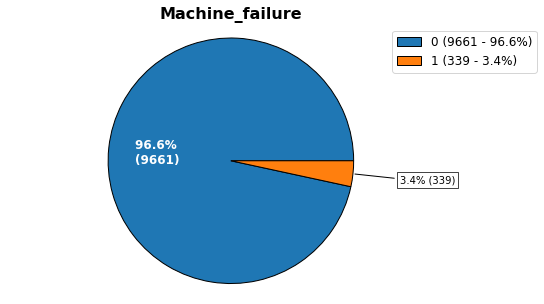

In [21]:
df_Machine_failure  = percentCol(df, 'Machine_failure')
pie_chart(df_Machine_failure , title='Machine_failure')

<div class="alert alert-block alert-warning">
        Failures
</div>

The machine failure consists of five independent failure modes<br>
- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).<br>
- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.<br>
- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.<br>
- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.<br>
- random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.<br>

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail<br>

In [22]:
df_failure = df[df["Machine_failure"]==1][["TWF", "HDF", "PWF", "OSF", "RNF"]]

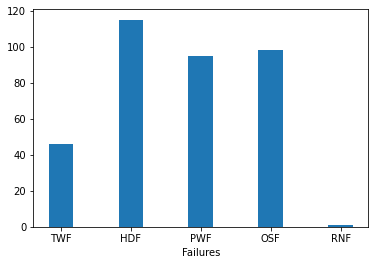

In [23]:
fig, ax = plt.subplots()
width = 0.35
x = [str(i) for i in df_failure.sum().index]
y = df_failure.sum().values
ax.bar(x, y, width)

ax.set_xlabel("Failures")
plt.show()

<div class="alert alert-block alert-warning">
        Balanced or imbalanced?
</div>

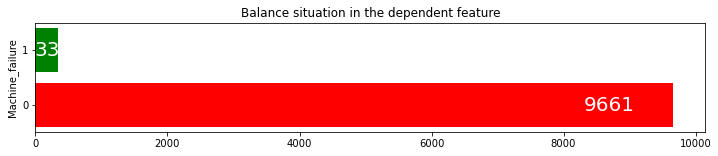

In [24]:
balanceOrInbalance(df_Machine_failure)

- The difference between 0 and 1 in the dependent feature is very high. So the dataset is in imbalance.

<div class="alert alert-block alert-success">
    <h4>
        Type
    </h4>
</div>

Consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants

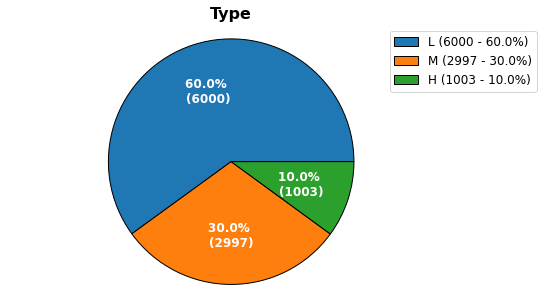

In [25]:
df_Type  = percentCol(df, 'Type')
pie_chart(df_Type , title='Type')

Machine_failure     0    1
Type                      
L                5765  235
M                2914   83
H                 982   21


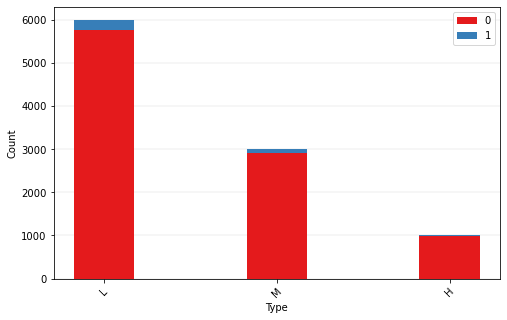

In [26]:
stacked_bar_chart(df, 'Type', 'Machine_failure')

<div class="alert alert-block alert-warning">
        One Hot Encoding
</div>

In [27]:
df = one_hot_encoding(train=df, ohe_col='Type')
df.head()

,UDI,Product_ID,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,1,M14860,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0,0,1
1,2,L47181,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,0,1,0
2,3,L47182,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,0,1,0
3,4,L47183,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,0,1,0
4,5,L47184,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Air temperature [K]
    </h4>
</div>

Generated using a random walk process later normalized to a standard deviation of 2 K around 300 K

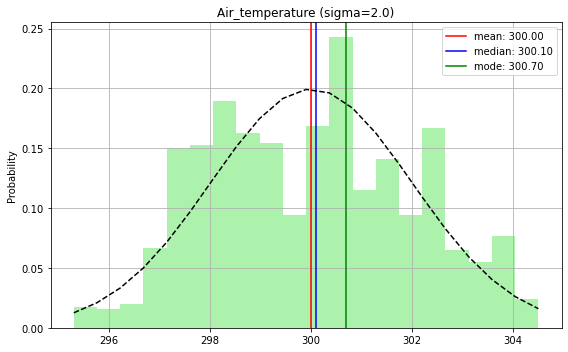

In [28]:
histogram(df, "Air_temperature")

In [29]:
print(f"min. Air_temperature: {df['Air_temperature'].min()}, \nmax. Air_temperature: \
{df['Air_temperature'].max()}")

min. Air_temperature: 295.3, 
max. Air_temperature: 304.5


<div class="alert alert-block alert-warning">
        Min-Max Scaler
</div>

In [30]:
df = featureScaler("minMax", df, 'Air_temperature')
df.head()

,UDI,Product_ID,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,1,M14860,0.304348,308.6,1551,42.8,0,0,0,0,0,0,0,0,0,1
1,2,L47181,0.315217,308.7,1408,46.3,3,0,0,0,0,0,0,0,1,0
2,3,L47182,0.304348,308.5,1498,49.4,5,0,0,0,0,0,0,0,1,0
3,4,L47183,0.315217,308.6,1433,39.5,7,0,0,0,0,0,0,0,1,0
4,5,L47184,0.315217,308.7,1408,40.0,9,0,0,0,0,0,0,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Process temperature [K]
    </h4>
</div>

Generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

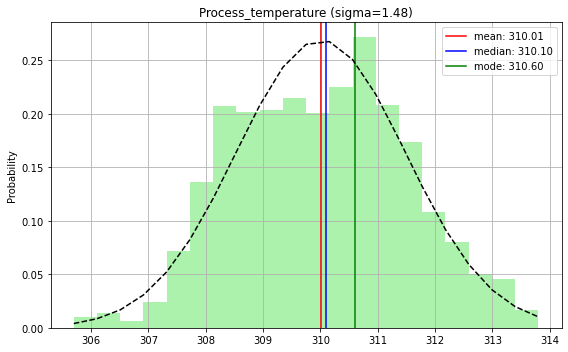

In [31]:
histogram(df, "Process_temperature")

In [32]:
print(f"min. Process_temperature: {df['Process_temperature'].min()}, \nmax. Process_temperature: \
{df['Process_temperature'].max()}")

min. Process_temperature: 305.7, 
max. Process_temperature: 313.8


<div class="alert alert-block alert-warning">
        Min-Max Scaler
</div>

In [33]:
df = featureScaler("minMax", df, 'Process_temperature')
df.head()

,UDI,Product_ID,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,1,M14860,0.304348,0.358025,1551,42.8,0,0,0,0,0,0,0,0,0,1
1,2,L47181,0.315217,0.370370,1408,46.3,3,0,0,0,0,0,0,0,1,0
2,3,L47182,0.304348,0.345679,1498,49.4,5,0,0,0,0,0,0,0,1,0
3,4,L47183,0.315217,0.358025,1433,39.5,7,0,0,0,0,0,0,0,1,0
4,5,L47184,0.315217,0.370370,1408,40.0,9,0,0,0,0,0,0,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Rotational speed [rpm]
    </h4>
</div>

Calculated from a power of 2860 W, overlaid with a normally distributed noise

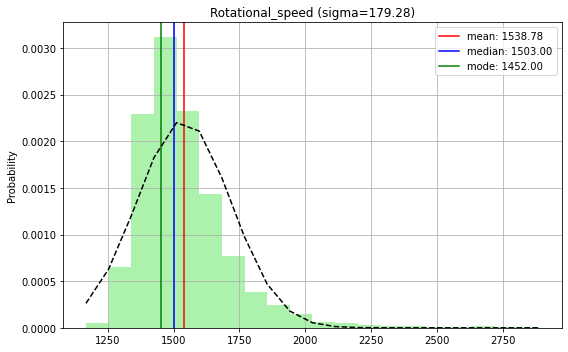

In [34]:
histogram(df, "Rotational_speed")

In [35]:
print(f"min. Rotational_speed: {df['Rotational_speed'].min()}, \nmax. Rotational_speed: \
{df['Rotational_speed'].max()}")

min. Rotational_speed: 1168, 
max. Rotational_speed: 2886


<div class="alert alert-block alert-warning">
        Min-Max Scaler
</div>

In [36]:
df = featureScaler("minMax", df, 'Rotational_speed')
df.head()

,UDI,Product_ID,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,1,M14860,0.304348,0.358025,0.222934,42.8,0,0,0,0,0,0,0,0,0,1
1,2,L47181,0.315217,0.370370,0.139697,46.3,3,0,0,0,0,0,0,0,1,0
2,3,L47182,0.304348,0.345679,0.192084,49.4,5,0,0,0,0,0,0,0,1,0
3,4,L47183,0.315217,0.358025,0.154249,39.5,7,0,0,0,0,0,0,0,1,0
4,5,L47184,0.315217,0.370370,0.139697,40.0,9,0,0,0,0,0,0,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Torque [Nm]
    </h4>
</div>

torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.

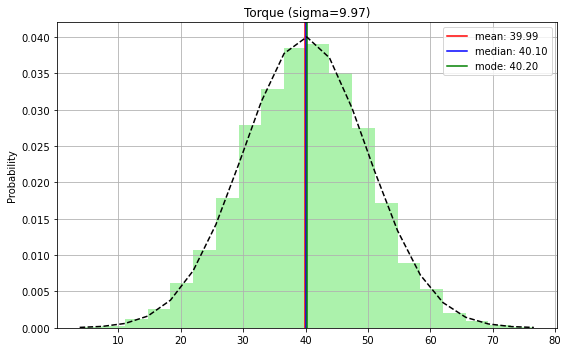

In [37]:
histogram(df, "Torque")

In [38]:
print(f"min. Torque: {df['Torque'].min()}, \nmax. Torque: {df['Torque'].max()}")

min. Torque: 3.8, 
max. Torque: 76.6


<div class="alert alert-block alert-warning">
        Min-Max Scaler
</div>

In [39]:
df = featureScaler("minMax", df, 'Torque')
df.head()

,UDI,Product_ID,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,1,M14860,0.304348,0.358025,0.222934,0.535714,0,0,0,0,0,0,0,0,0,1
1,2,L47181,0.315217,0.370370,0.139697,0.583791,3,0,0,0,0,0,0,0,1,0
2,3,L47182,0.304348,0.345679,0.192084,0.626374,5,0,0,0,0,0,0,0,1,0
3,4,L47183,0.315217,0.358025,0.154249,0.490385,7,0,0,0,0,0,0,0,1,0
4,5,L47184,0.315217,0.370370,0.139697,0.497253,9,0,0,0,0,0,0,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Tool wear [min]
    </h4>
</div>

The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

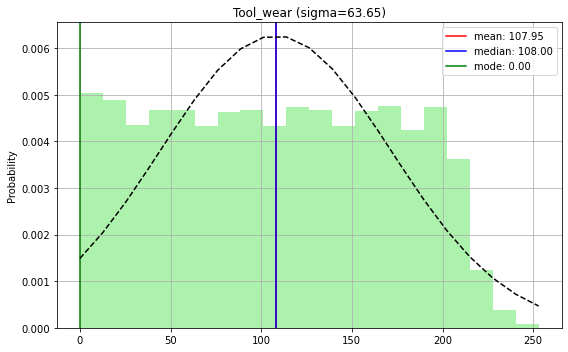

In [40]:
histogram(df, "Tool_wear")

<div class="alert alert-block alert-warning">
        Min-Max Scaler
</div>

In [41]:
df = featureScaler("minMax", df, 'Tool_wear')
df.head()

,UDI,Product_ID,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,1,M14860,0.304348,0.358025,0.222934,0.535714,0.000000,0,0,0,0,0,0,0,0,1
1,2,L47181,0.315217,0.370370,0.139697,0.583791,0.011858,0,0,0,0,0,0,0,1,0
2,3,L47182,0.304348,0.345679,0.192084,0.626374,0.019763,0,0,0,0,0,0,0,1,0
3,4,L47183,0.315217,0.358025,0.154249,0.490385,0.027668,0,0,0,0,0,0,0,1,0
4,5,L47184,0.315217,0.370370,0.139697,0.497253,0.035573,0,0,0,0,0,0,0,1,0


<div class="alert alert-block alert-success">
    <h4>
        Drop features
    </h4>
</div>

In [42]:
df = df.drop(["UDI", "Product_ID", "TWF", "HDF", "PWF", "OSF", "RNF"], axis=1)

<div class="alert alert-block alert-success">
    <h4>
        Move the label column to end and encodes it
    </h4>
</div>

In [43]:
new_cols_order = [i for i in df.columns if not i in "Machine_failure"] + ["Machine_failure"]
df = df.loc[:, new_cols_order]
df.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_H,Type_L,Type_M,Machine_failure
0,0.304348,0.358025,0.222934,0.535714,0.000000,0,0,1,0
1,0.315217,0.370370,0.139697,0.583791,0.011858,0,1,0,0
2,0.304348,0.345679,0.192084,0.626374,0.019763,0,1,0,0
3,0.315217,0.358025,0.154249,0.490385,0.027668,0,1,0,0
4,0.315217,0.370370,0.139697,0.497253,0.035573,0,1,0,0


<a id='5.0'></a>
<div class="alert alert-block alert-danger">
<h2>Machine Learning Algorithms and Results</h2>
</div>

<a id='5.1'></a>
<div class="alert alert-block alert-info">
   <h3>
        Feature engineering
   </h3>
</div>

In [44]:
X = df.drop(['Machine_failure'], axis=1)
y = df['Machine_failure']

print(X.shape)

(10000, 8)


<div class="alert alert-block alert-success">
    <h4>
        Check categorical columns
    </h4>
</div>

In [45]:
categorical_feature_cols = list(set(df.columns) - set(df._get_numeric_data().columns))
categorical_feature_cols

[]

- There is no categorical columns in the dataframe

In [46]:
numerical_feature_cols = list(X._get_numeric_data().columns)
print(numerical_feature_cols)

['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear', 'Type_H', 'Type_L', 'Type_M']


<div class="alert alert-block alert-success">
    <h4>
        Constant and quasi constant features removal
    </h4>
</div>

- Constant: remove the features that have the same value in all samples
- Quasi constant : remove the features that they have the 99% same value

<div class="alert alert-block alert-warning">
        Constant
</div>

In [47]:
from sklearn.feature_selection import VarianceThreshold
constant=VarianceThreshold(threshold=0)
constant.fit(df)

constant_columns = [column for column in df.columns
                    if column not in df.columns[constant.get_support()]]
print(len(constant_columns))

0


<div class="alert alert-block alert-warning">
        Quasi constant
</div>

In [48]:
from sklearn.feature_selection import VarianceThreshold
quasi_constant=VarianceThreshold(threshold=0.01)
quasi_constant.fit(df)

quasi_constant_columns = [column for column in df.columns
                    if column not in df.columns[quasi_constant.get_support()]]
print(quasi_constant_columns)

[]


<div class="alert alert-block alert-success">
    <h4>
        Remove duplicate features
    </h4>
</div>

In [49]:
X_T = X.T
print(X_T.duplicated().sum())

0


- There are no dublicated features

<div class="alert alert-block alert-success">
    <h4>
        Drop highly correlated features using Pearson Correlation
    </h4>
</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/3/34/Correlation_coefficient.png" style="height:250px">

Pearson correlation coefficient
- a measure of linear correlation between features
- the measure can only reflect a linear correlation of variables, and ignores many other types of relationship or correlation
- the result always has a value between −1 and 1

In [50]:
def highly_correlated_features(df, threshold):
    corr_matrix = df.corr()
    
    df_corr_list = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                ind_name = corr_matrix.columns[i]
                col_name = corr_matrix.columns[j]
                coeff_value_absolute = abs(corr_matrix.iloc[i, j])
                df_corr_list.append([ind_name, col_name, coeff_value_absolute])
                
    df_corr = pd.DataFrame(df_corr_list, columns=['Feature_1', 'Feature_2', 'Corr_value'])
    
    return df_corr
        
df_hcf = highly_correlated_features(df, 0.85)
df_hcf = df_hcf.sort_values(by=['Feature_1', 'Feature_2', 'Corr_value'], ascending=False)
df_hcf

,Feature_1,Feature_2,Corr_value
1,Torque,Rotational_speed,0.875027
0,Process_temperature,Air_temperature,0.876107


<div class="alert alert-block alert-warning">
        Feature importance based on RandomForestClassifier 
</div>

- create correlated feature groups using the highly_correlated_features dataframe (df_hcf)
- only one feature will be selected from each group using RandomForestClassifier
- other features in each group will be removed

In [51]:
from sklearn.ensemble import RandomForestClassifier

# the list is used to check if each feature is in previous groups
grouped_feature_list = []
# the items in the list will be removed from the X_train and X_test
dropped_feature_list = []

for feature in df_hcf['Feature_1'].unique():
    if feature not in grouped_feature_list:
        # group the highly_correlated_features dataframe (df_hcf)
        df_feature = df_hcf[df_hcf['Feature_1'] == feature]        
        
        correlated_features_list = [feature] + list(df_feature['Feature_2'].unique())
        grouped_feature_list = grouped_feature_list + correlated_features_list

        rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
        rf.fit(df[correlated_features_list], y)
        # create an importance dataframe using the feature_importances_ values
        df_importance = pd.concat([pd.Series(correlated_features_list), pd.Series(rf.feature_importances_)], 
                               axis=1)
        df_importance.columns = ['Feature', 'Importance']
        df_importance.sort_values(by = 'Importance', ascending=False, inplace=True)
        # get the feature names except the one that has the highest improtance from the df_importance
        dropped_feature_list = dropped_feature_list + list(df_importance['Feature'][1:].values)
    
print(dropped_feature_list)  

['Rotational_speed', 'Process_temperature']


In [52]:
# drop the highly correlated features 
X = X.drop(dropped_feature_list, axis=1)
print(X.shape)

(10000, 6)


<div class="alert alert-block alert-success">
    <h4>
        SelectFromModel using Logistic Regression
    </h4>
</div>

In [53]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def feature_selection(model, X_train, y_train):
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    cvs = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    acc = cvs.mean()
    
    return acc

SelectFromModel<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html?highlight=selectfrommodel#sklearn.feature_selection.SelectFromModel
- SelectFromModel can be used alongside any estimator that assigns importance to each feature through a specific attribute (such as coef_, feature_importances_). 

Parameters
- estimator: The estimator should have a feature_importances_ or coef_ attribute after fitting. Otherwise, the importance_getter parameter should be used
- threshold: “mean” is used by default

In [54]:
from sklearn.feature_selection import SelectFromModel as SFM
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1)
sfm = SFM(model).fit(X, y)
cols_SFM = X.columns[sfm.get_support()].tolist()
print(cols_SFM)

acc = feature_selection(model, X, y)
acc_SFM = feature_selection(model, X[cols_SFM], y)

print('The Accuracy all features: {:.1%}'.format(acc))
print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))

['Air_temperature', 'Torque', 'Tool_wear']
The Accuracy all features: 96.7%
The Accuracy selected features with SFM: 96.7%


<div class="alert alert-block alert-success">
    <h4>
        GenericUnivariateSelect and ANOVA F-value
    </h4>
</div>

In [55]:
from sklearn.feature_selection import SelectFromModel as SFM
from sklearn.linear_model import LogisticRegression

def best_features (model, X_train, y_train, cols_sel, cols_SFM, acc, acc_SFM):
    cols_model_best = []
    acc_model_best = 0
    for col in cols_sel:
        if col not in cols_SFM:
            cols_SFM = cols_SFM + [col]
            cv = KFold(n_splits=10, random_state=0, shuffle=True)
            cvs_model = cross_val_score(model, X_train[cols_SFM], y_train, scoring='accuracy', cv=cv)
            acc_model = cvs_model.mean()
            if (acc_model > acc_SFM) & (acc_model > acc_model_best):
                cols_model_best = cols_SFM
                acc_model_best = acc_model
                print(cols_model_best)
                print('The Accuracy all features: {:.1%}'.format(acc))
                print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))
                print('The Accuracy selected features with MODEL: {:.1%}'.format(acc_model_best))
                print('=====')

GenericUnivariateSelect<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html
- Univariate feature selection works by selecting the best features based on univariate statistical tests. 
- GenericUnivariateSelect allows to perform univariate feature selection with a configurable strategy. This allows to select the best univariate selection strategy with hyper-parameter search estimator.

Parameters

- score_func, default=f_classif
- mode: Feature selection mode {‘percentile’, ‘k_best’, ‘fpr’, ‘fdr’, ‘fwe’}, default=’percentile’
- param: Parameter of the corresponding mode

In [56]:
from sklearn.feature_selection import GenericUnivariateSelect as GUS
# ANOVA F-value between label/feature for classification tasks.
from sklearn.feature_selection import f_classif

gus_f = GUS(f_classif, mode='k_best', param=len(X.columns)).fit(X, y)
cols_gus_f = X.columns[gus_f.get_support()].tolist()

best_features(model, X, y, cols_gus_f, cols_SFM, acc, acc_SFM)

<div class="alert alert-block alert-success">
    <h4>
        SelectKBest and Mutual Information
    </h4>
</div>

SelectKBest<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html?highlight=selectkbest#sklearn.feature_selection.SelectKBest
- Univariate feature selection works by selecting the best features based on univariate statistical tests. 
- SelectKBest removes all but the  highest scoring features

Parameters

- score_func, default=f_classif
- k, default=10: Number of top features to select

In [57]:
from sklearn.feature_selection import SelectKBest
# Mutual information for a discrete target.
from sklearn.feature_selection import mutual_info_classif

# select the  top k important features
KBest_m = SelectKBest(mutual_info_classif, k=len(X.columns)).fit(X, y)
cols_KBest_m = X.columns[KBest_m.get_support()].tolist()

best_features(model, X, y, cols_KBest_m, cols_SFM, acc, acc_SFM)

<div class="alert alert-block alert-success">
    <h4>
        RFE (Recursive feature elimination)
    </h4>
</div>

RFE<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html?highlight=rfe#sklearn.feature_selection.RFE
- Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.

Parameters

- estimator: A supervised learning estimator with a fit method that provides information about feature importance (e.g. coef_, feature_importances_)
- n_features_to_select, default=None: Number of top features to select

In [58]:
from sklearn.feature_selection import RFE

new_cols_RFE = cols_SFM.copy()
acc_RFE_best = 0
new_cols_RFE_best = []

for i in range(10, len(X.columns)+1):
    selector = RFE(estimator=model, n_features_to_select=i).fit(X, y)
    new_cols_RFE = X.columns[selector.get_support()]
    
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    cvs_RFE = cross_val_score(model, X[new_cols_RFE], y, scoring='accuracy', cv=cv)
    acc_RFE = cvs_RFE.mean()
    
    if acc_RFE > acc_RFE_best:
        acc_RFE_best = acc_RFE
        new_cols_RFE_best = new_cols_RFE
        
        print(new_cols_RFE_best)
        print('The Accuracy all features: {:.1%}'.format(acc))
        print('The Accuracy selected features with SFM: {:.1%}'.format(acc_SFM))
        print('The Accuracy selected features with KBest: {:.1%}'.format(acc_RFE_best))
        print('=====')

<a id='5.2'></a>
<div class="alert alert-block alert-info">
   <h3>
        Correlation of the features
   </h3>
</div>

In [59]:
def create_heatmap(hm, figsize=(16, 8)):
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(hm, cmap='viridis', aspect='auto')

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(hm.columns)))
    ax.set_yticks(np.arange(len(hm.columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(hm.columns)
    ax.set_yticklabels(hm.columns)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)
    ax.set_xticks(np.arange(hm.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(hm.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(hm.columns)):
        for j in range(len(hm.columns)):
            hm_val = round(hm.values[i, j], 2)
            if hm_val > 0.85:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="black", size=16)
            else:
                text = ax.text(j, i, hm_val,
                               ha="center", va="center", color="w", size=16)

    fig.tight_layout()
    plt.show()

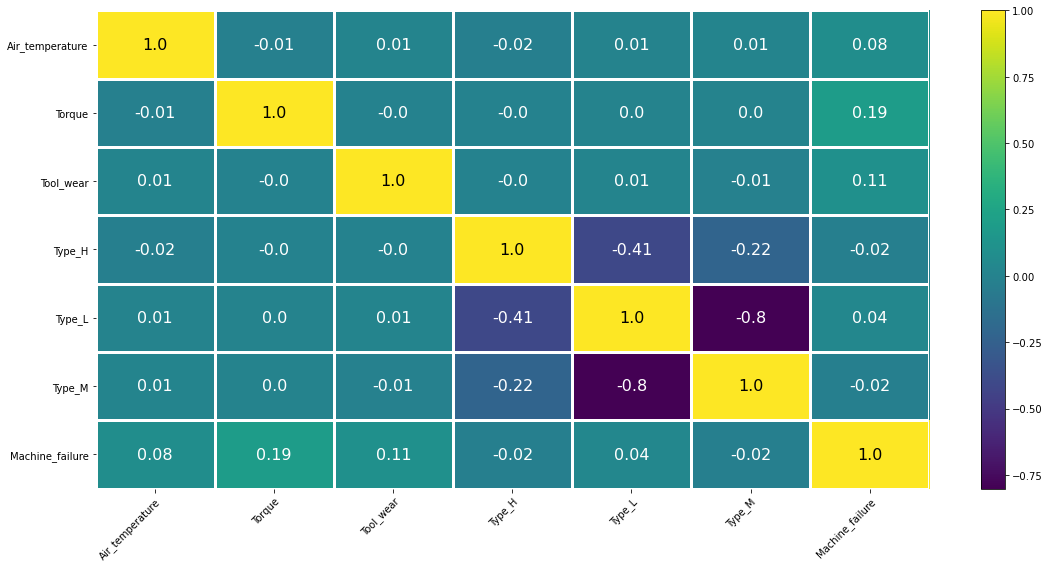

In [60]:
hm_train_new = pd.concat([X, y], axis=1).corr()
create_heatmap(hm_train_new)

In [61]:
cols_dropped = list(hm_train_new[(hm_train_new["Machine_failure"] > -0.03)&\
                                 (hm_train_new["Machine_failure"] < 0.03)]["Machine_failure"].index)
print(cols_dropped)

['Type_H', 'Type_M']


In [62]:
X.drop(cols_dropped, axis=1, inplace=True)

<a id='5.3'></a>
<div class="alert alert-block alert-info">
   <h3>
        Split Dataframe
   </h3>
</div>

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.30, random_state=0)

print(X_train.shape)
print(X_test.shape)

(7000, 4)
(3000, 4)


<a id='5.4'></a>
<div class="alert alert-block alert-info">
   <h3>
        Overcoming Class Imbalance using SMOTE
   </h3>
</div>

- It is an imbalanced data where the target variable
- SMOTE: Synthetic Minority Oversampling Technique will be used for creating synthesized data
- A comparative analysis will be done on the dataset using RandomForestClassifier
- The accuracy metric will be ignored to evaluate the performance of the classifier on this imbalanced dataset
- Precision, recall, F1-score metrics will be taken into account 

<div class="alert alert-block alert-warning">
        SMOTE: Synthetic Minority Oversampling Technique
</div>

- SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.
- Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

<img src="https://editor.analyticsvidhya.com/uploads/64068image3.png" style="height:250px">

In [64]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', n_jobs=-1)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [65]:
df_Failure_smote = percentCol(pd.concat([X_train_sm, y_train_sm], axis=1), 'Machine_failure')

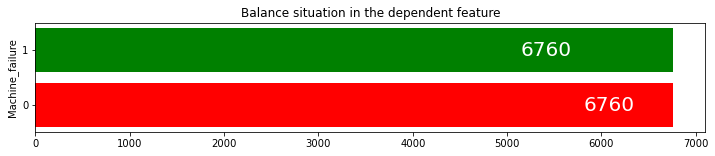

In [67]:
balanceOrInbalance(df_Failure_smote)

<div class="alert alert-block alert-success">
    <h4>
        Comparison
    </h4>
</div>

<div class="alert alert-block alert-warning">
        Before
</div>

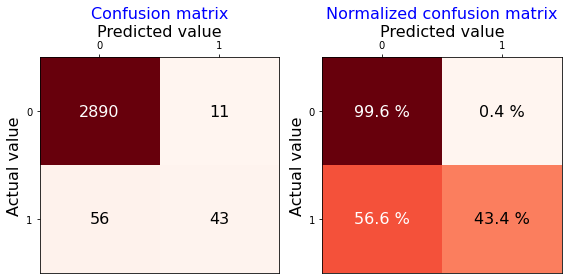

In [68]:
from sklearn.ensemble import RandomForestClassifier

params = {}
rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
rf_cm_metrics, rf_pred = evaluate_model(rf, X_train, y_train, X_test, y_test, params)

<div class="alert alert-block alert-warning">
        After
</div>

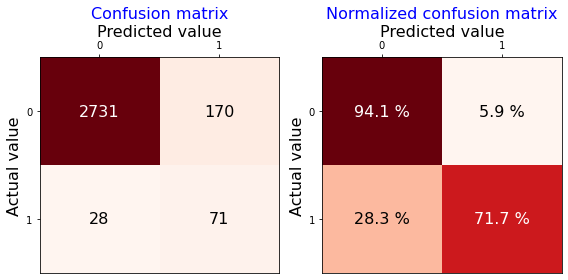

In [69]:
from sklearn.ensemble import RandomForestClassifier

params = {}
rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
rf_cm_metrics, rf_pred = evaluate_model(rf, X_train_sm, y_train_sm, X_test, y_test, params)

<a id='5.5'></a>
<div class="alert alert-block alert-info">
   <h3>
        Building ML models
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        Logistic
    </h4>
</div>

<img src="https://static.javatpoint.com/tutorial/machine-learning/images/logistic-regression-in-machine-learning.png" style="height:150px">

best prarams: {}


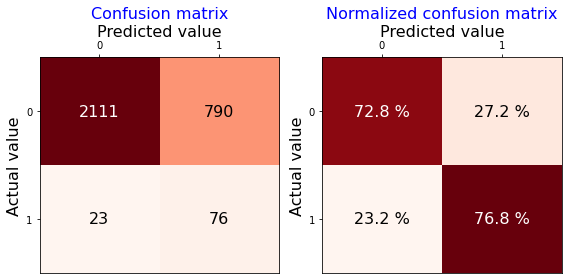

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(penalty='l2', C=1, solver='sag', max_iter=150, multi_class='ovr')
params = {
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'C': [i for i in np.arange(1, 5, 1)],
#     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'max_iter': [i for i in np.arange(1, 15, 1)],
#     'multi_class': ['auto', 'ovr', 'multinomial'],
         }
clf_log = GridSearchCV(estimator=log, cv=10, scoring='accuracy', param_grid=params).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_log.best_params_)

log_cm_metrics, log_pred = evaluate_model(log, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Random Forest
    </h4>
</div>

<img src="https://406167-1278791-raikfcquaxqncofqfm.stackpathdns.com/wp-content/uploads/2021/02/Random-Forest-Algorithm-1024x576.jpg" style="height:250px">

best prarams: {}


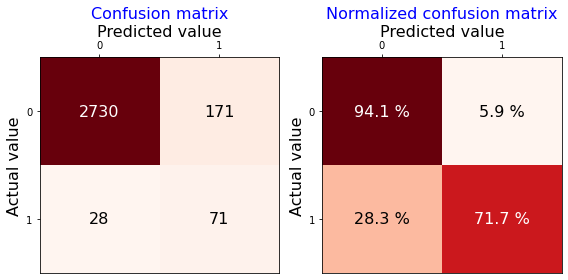

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=25, 
                            min_samples_split=5)
params = {
#     'criterion': ['gini', 'entropy'],
#     'n_estimators': [10,20,30,50, 100, 125, 150, 200],
#     'max_depth': [i for i in np.arange(1, 15, 1)],
#     'min_samples_split': [i for i in np.arange(1, 15, 1)],
#     'min_samples_leaf': [i for i in np.arange(1, 15, 1)],
         }
clf_rf = GridSearchCV(estimator=rf, cv=10, scoring='accuracy', param_grid=params, n_jobs=-1)\
.fit(X_train_sm, y_train_sm)
print('best prarams:', clf_rf.best_params_)

rf_cm_metrics, rf_pred = evaluate_model(rf, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Naive Bayes
    </h4>
</div>

<img src="https://www.researchgate.net/profile/Paolo-Dellaversana/publication/328020065/figure/fig5/AS:677213301121033@1538471641906/Naive-Bayes-classification-of-three-different-rock-types-based-on-nine-mineralogical.png" style="height:200px">

best prarams: {}
CPU times: user 105 ms, sys: 13.8 ms, total: 119 ms
Wall time: 137 ms


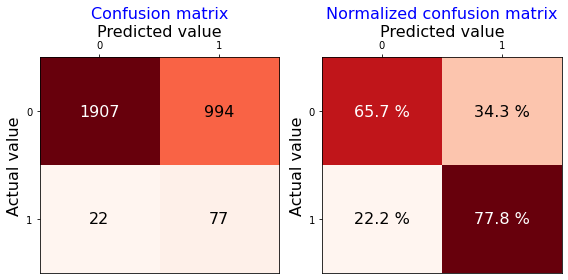

In [83]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bNB = BernoulliNB(alpha=0.5, binarize=1.5, fit_prior=False)
bNB = BernoulliNB(alpha=0.0, binarize=0.5, fit_prior=False)
params = {
#     'alpha': [0, 0.1, 0.5, 1.0, 1.5, 2.0, 2.5],
#     'binarize': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5],
#     'fit_prior': [False, True],
         }
clf_bNB = GridSearchCV(estimator=bNB, cv=10, scoring='accuracy', param_grid=params, 
n_jobs=-1).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_bNB.best_params_)

bNB_cm_metrics, bNB_pred = evaluate_model(bNB, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        SVM
    </h4>
</div>

<img src="https://miro.medium.com/max/410/1*MHtUN-DgYPZWPe2dU5G6Lg.png" style="height:200px">

best prarams: {}
CPU times: user 53 s, sys: 1.12 s, total: 54.1 s
Wall time: 1min 6s


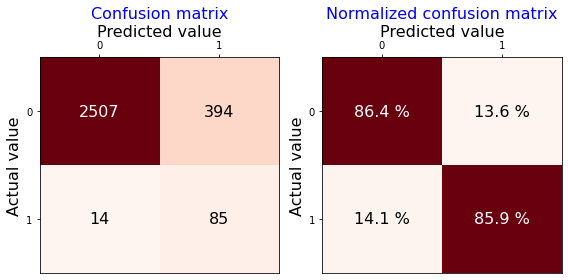

In [84]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm = SVC(C=2.5, kernel='rbf', degree=0.1, probability=True)

params = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'C': [0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5],
#     'degree': [0,0.01,0.02,0.03,0.04],
         }
clf_svm = GridSearchCV(estimator=svm, cv=10, scoring='accuracy', param_grid=params, 
n_jobs=-1).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_svm.best_params_)

svm_cm_metrics, svm_pred = evaluate_model(svm, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        k-Nearest Neighbours
    </h4>
</div>

<img src="https://www.kdnuggets.com/wp-content/uploads/rapidminer-knn-image1.jpg" style="height:200px">

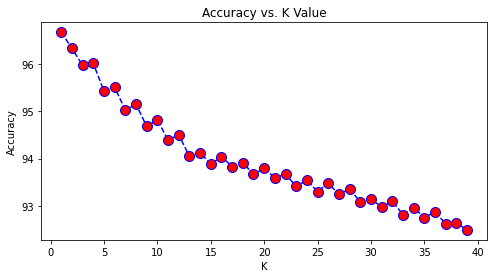

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

acc_list = []
for k in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_sm, y_train_sm)
    cv = KFold(n_splits=10, random_state=0, shuffle=True)
    accuracy_scores = cross_val_score(knn, X_train_sm, y_train_sm, scoring='accuracy', cv=cv, n_jobs=-1)
    acc_knn = round(accuracy_scores.mean()*100, 2)
#     acc_knn = evaluate_model(knn, X_train_sm, y_train_sm)
    acc_list.append(acc_knn)
    
plt.figure(figsize=(8,4))
plt.plot(range(1,40),acc_list,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [95]:
k_max_list = [i for i in acc_list]
k_max = acc_list.index(max(k_max_list))+1
print(k_max)

1


best prarams: {}
CPU times: user 515 ms, sys: 15.4 ms, total: 530 ms
Wall time: 652 ms


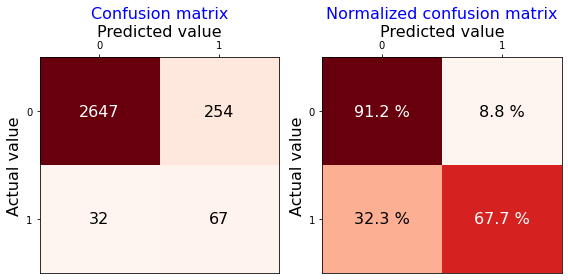

In [96]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='auto', leaf_size=5, weights='uniform', p=4)

params = {
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#     'leaf_size': [i for i in np.arange(0, 15, 1)],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2, 3, 4, 5, 6],
         }
clf_knn = GridSearchCV(estimator=knn, cv=10, scoring='accuracy', param_grid=params, 
n_jobs=-1).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_knn.best_params_)

knn_cm_metrics, knn_pred = evaluate_model(knn, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Stochastic Gradient Descent
    </h4>
</div>

<img src="https://miro.medium.com/max/1005/1*f0CuPDSWFUr9XGESWQ4JUA.png" style="height:200px">

best prarams: {}
CPU times: user 288 ms, sys: 89.4 ms, total: 378 ms
Wall time: 295 ms


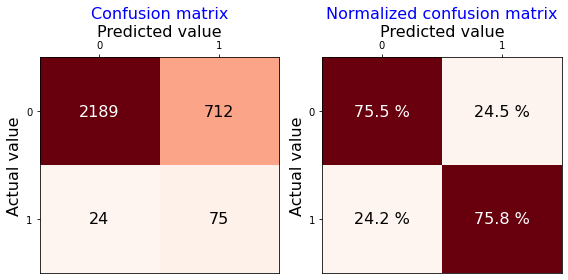

In [108]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(loss='log', penalty='l1', alpha=0.0005, eta0=0.01, learning_rate='invscaling',
                    power_t=0.01, validation_fraction=0.07, n_iter_no_change=9)

params = {
#     'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 
#              'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
#     'penalty': ['l1', 'l2', 'elasticnet'],
#     'alpha': [i for i in np.arange(0.0001, 0.001, 1/10000)],
#     'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
#     'eta0': [0.01, 0.03, 0.05, 0.07],
#     'power_t': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3],
#     'validation_fraction': [0.01, 0.03, 0.05, 0.07, 0.1, 0.2],
#     'n_iter_no_change': [1, 3, 5, 7, 9, 11],
         }
clf_sgdc = GridSearchCV(estimator=sgdc, cv=10, scoring='accuracy', param_grid=params, 
n_jobs=-1).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_sgdc.best_params_)

sgdc_cm_metrics, sgdc_pred = evaluate_model(sgdc, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        Gradient Boosting Trees
    </h4>
</div>

<img src="https://miro.medium.com/max/788/1*pEu2LNmxf9ttXHIALPcEBw.png" style="height:200px">

best prarams: {}
CPU times: user 27.9 s, sys: 174 ms, total: 28.1 s
Wall time: 33.9 s


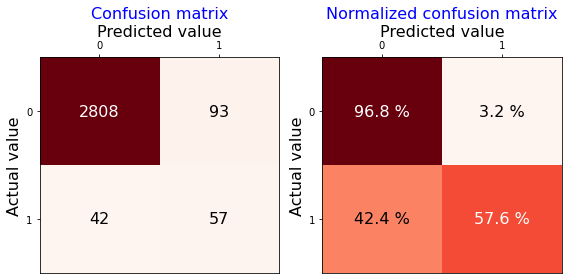

In [109]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.05, n_estimators=120, 
                                 subsample=0.9, criterion='mse', max_depth=4)
gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.35, n_estimators=120,
                                 subsample=0.95, max_depth=8
                                )

params = {
#         'loss': ['deviance', 'exponential'],
#     'learning_rate': [0.3, 0.35, 0.45, 0.5, 0.6, 0.65, ],
#     'n_estimators': [0,1,2,3,4,5,6,7],
#     'subsample':[0.9,0.95,1,1.1],
#     'criterion': ['friedman_mse', 'mse', 'mae'],
#     'max_depth': [1,2,3,4,6,7,8,9],
         }
clf_gbc = GridSearchCV(estimator=gbc, cv=10, scoring='accuracy', param_grid=params, 
n_jobs=-1).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_gbc.best_params_)

gbc_cm_metrics, gbc_pred = evaluate_model(gbc, X_train_sm, y_train_sm, X_test, y_test, params)

<div class="alert alert-block alert-success">
    <h4>
        xgboost -> XGBClassifier
    </h4>
</div>

best prarams: {}
CPU times: user 4.14 s, sys: 111 ms, total: 4.25 s
Wall time: 3.95 s


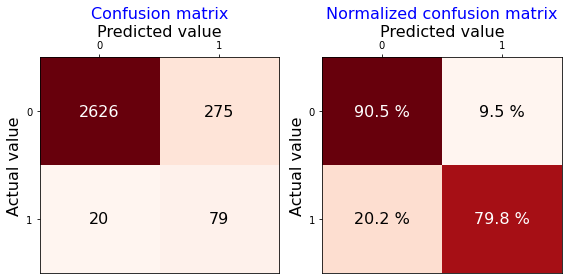

In [110]:
%%time
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

xgb = XGBClassifier(booster='gbtree', eval_metric='logloss', sketch_eps=0.0, eta=0.07, max_depth=4, 
                min_child_weight=2.8, n_estimators=80, max_delta_step=2, subsample=1, use_label_encoder=False)

params = {
#     'sketch_eps': [i for i in np.arange(0, 0.1, 1/100)],
#     'eta': [0.01,0.03,0.05,0.07,0.09],
#     'max_depth': [i for i in np.arange(0, 15, 1)],
#     'n_estimators': [90,95,100,110],
#     'min_child_weight' : [2.5,2.6,2.7,2.8,2.9,3],
#     'max_delta_step':[0,1,1.5,2],
#     'subsample':[0.9,0.95,1]
         }
clf_xgb = GridSearchCV(estimator=xgb, cv=5, scoring='accuracy', param_grid=params).fit(X_train_sm, y_train_sm)
print('best prarams:', clf_xgb.best_params_)

xgb_cm_metrics, xgb_pred = evaluate_model(xgb, X_train_sm, y_train_sm, X_test, y_test, params)

<a id='5.6'></a>
<div class="alert alert-block alert-info">
   <h3>
        Model selection - final
   </h3>
</div>

In [111]:
'''
    # accuracy (ACC)
    ACC = round((TP + TN) / (TP + TN + FP + FN), 2)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = round(TP / (TP + FN), 2)
    
    # Specificity, selectivity or true negative rate (TNR)
    TNR = round(TN / (TN + FP), 2)
    
    # Precision or positive predictive value
    PPV = round(TP / (TP + FP), 2)
    
    # F1 score
    F1 = round(2*TP / (2*TP + FP + FN), 2)
'''

metrics = ["Accuracy", "True Negative Rate", "True Positive Rate", "Precision", "F1 Score"]

log_metrics = log_cm_metrics.loc[:, metrics]
rf_metrics = rf_cm_metrics.loc[:, metrics]
bNB_metrics = bNB_cm_metrics.loc[:, metrics]
svm_metrics = svm_cm_metrics.loc[:, metrics]
knn_metrics = knn_cm_metrics.loc[:, metrics]
sgdc_metrics = sgdc_cm_metrics.loc[:, metrics]
gbc_metrics = gbc_cm_metrics.loc[:, metrics]
xgb_metrics = xgb_cm_metrics.loc[:, metrics]

df_models = pd.concat([log_metrics, rf_metrics, bNB_metrics, svm_metrics, knn_metrics, sgdc_metrics, 
                       gbc_metrics, xgb_metrics], axis=0)
df_models.index = ["log", "rf", "bNB", "svm", "knn", "sgdc", "gbc", "xgb"]
df_models = df_models.sort_values(["Accuracy", "True Positive Rate"], ascending=False)
df_models

,Accuracy,True Negative Rate,True Positive Rate,Precision,F1 Score
gbc,0.96,0.97,0.58,0.38,0.46
rf,0.93,0.94,0.72,0.29,0.42
xgb,0.90,0.91,0.80,0.22,0.35
knn,0.90,0.91,0.68,0.21,0.32
svm,0.86,0.86,0.86,0.18,0.29
sgdc,0.75,0.75,0.76,0.10,0.17
log,0.73,0.73,0.77,0.09,0.16
bNB,0.66,0.66,0.78,0.07,0.13


<a id='5.7'></a>
<div class="alert alert-block alert-info">
   <h3>
        Evaluation of the selected model
   </h3>
</div>

<div class="alert alert-block alert-success">
    <h4>
        ROC & AUC
    </h4>
</div>

<div class="alert alert-block alert-warning">
        XGBClassifier selected
</div>

In [112]:
y_test_prob = xgb_pred[:,1]

In [113]:
%%time
tpr_list = []
tnr_list = []
fpr_list = []
acc_list = []
thresholds_list = []
precision_list = []
npv_list = []

for i in range(0, 1000, 1):
    y_test_pred = (y_test_prob >= i/1000).astype('int')
    cm_train = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm_train.ravel()
    
    #____________ METRICS ____________#
    # Sensitivity, hit rate, recall, or true positive rate
    TPR_train = round(TP / (TP + FN), 2)
    # Specificity, selectivity or true negative rate (TNR)
    TNR_train = round(TN / (TN + FP), 2)
    # False positive rate or False alarm rate
    FPR_train = round(FP / (FP + TN), 2)
    # accuracy (ACC)
    acc_train = round((TP + TN) / (TP + TN + FP + FN), 2)
    # Precision or positive predictive value
    precision_train = round(TP / (TP + FP), 2)
    # negative predictive value (NPV)
    npv_train = round(TN / (TN + FN), 2)    

    tpr_list.append(TPR_train)
    tnr_list.append(TNR_train)
    fpr_list.append(FPR_train)
    acc_list.append(acc_train)
    thresholds_list.append(i/1000)
    precision_list.append(precision_train)
    npv_list.append(npv_train)

CPU times: user 1.1 s, sys: 5.83 ms, total: 1.1 s
Wall time: 1.1 s


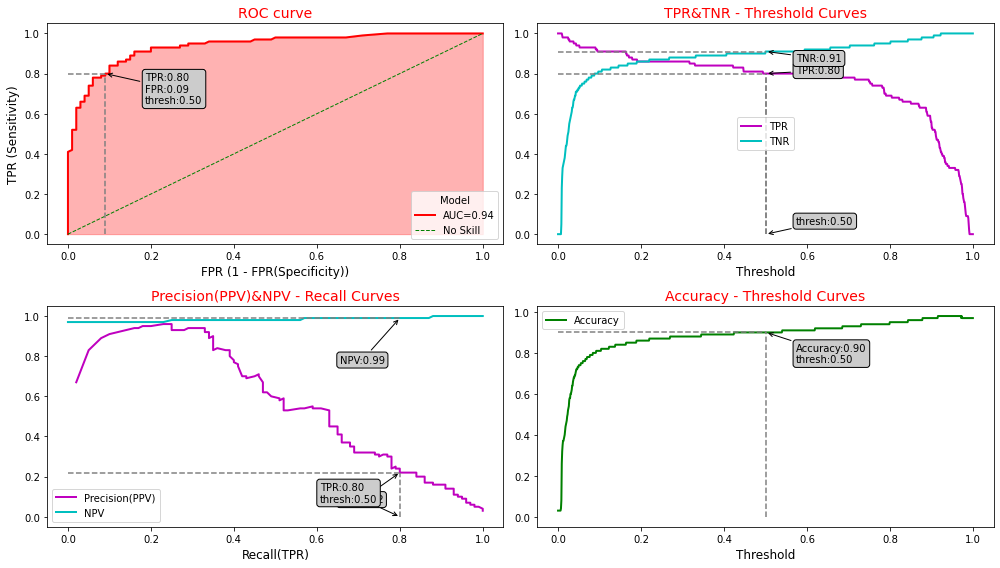

In [114]:
from sklearn.metrics import roc_auc_score

threshold=0.5
idx = next(x[0] for x in enumerate(thresholds_list) if x[1] > threshold)

# compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
lr_auc = roc_auc_score(y_test, y_test_prob)

#############################
# Set up the matplotlib figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
#############################
### ROC Curve ###

axes[0, 0].plot(fpr_list, tpr_list, color='red', linewidth=2, 
                label=f'AUC={lr_auc:.2f}')
axes[0, 0].fill_between(fpr_list, tpr_list, 0, color='red', alpha=0.3)
axes[0, 0].plot([0, 1], [0, 1], color='green', linestyle='--', linewidth=1,
                label='No Skill')

axes[0, 0].set_xlabel('FPR (1 - FPR(Specificity))', size=12)
axes[0, 0].set_ylabel('TPR (Sensitivity)', size=12)
axes[0, 0].legend(title='Model')
axes[0, 0].set_title('ROC curve', color='red', size=14)

# Annotate #
axes[0, 0].plot([0,fpr_list[idx]], [tpr_list[idx],tpr_list[idx]], 'k--', color='gray')
axes[0, 0].plot([fpr_list[idx],fpr_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 0].annotate(
    f'TPR:{tpr_list[idx]:.2f}\nFPR:{fpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (fpr_list[idx], tpr_list[idx]), xytext =(-2 * -20, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### TPR and FPR at every threshold ###

axes[0, 1].plot(thresholds_list, tpr_list, color='m', linewidth=2, label='TPR')
axes[0, 1].plot(thresholds_list, tnr_list, color='c', linewidth=2, label='TNR')
axes[0, 1].set_xlabel('Threshold', size=12)
axes[0, 1].legend()
axes[0, 1].set_title('TPR&TNR - Threshold Curves', color='red', size=14)

axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')


# Annotate #
axes[0, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tpr_list[idx] ,tpr_list[idx]], 'k--', color='gray')
axes[0, 1].plot([0, thresholds_list[idx]], [tnr_list[idx] ,tnr_list[idx]], 'k--', color='gray')

axes[0, 1].annotate(
    f'TPR:{tpr_list[idx]:.2f}',
    (thresholds_list[idx], tpr_list[idx]), xytext =(-2 * -15, 0), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(
    f'TNR:{tnr_list[idx]:.2f}',
    (thresholds_list[idx], tnr_list[idx]), xytext =(-2 * -15, -10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

axes[0, 1].annotate(f'thresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], 0), xytext =(-2 * -15, 10), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Precision-Recall Curve ###

axes[1, 0].plot(tpr_list, precision_list, color='m', linewidth=2, label='Precision(PPV)')
axes[1, 0].plot(tpr_list, npv_list, color='c', linewidth=2, label='NPV')

axes[1, 0].set_xlabel('Recall(TPR)', size=12)
axes[1, 0].legend()
axes[1, 0].set_title('Precision(PPV)&NPV - Recall Curves', color='red', size=14)

# Annotate
axes[1, 0].plot([tpr_list[idx],tpr_list[idx]], [0,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [precision_list[idx] ,precision_list[idx]], 'k--', color='gray')
axes[1, 0].plot([0, tpr_list[idx]], [npv_list[idx] ,npv_list[idx]], 'k--', color='gray')

axes[1, 0].annotate(f'PPV:{precision_list[idx]:.2f}',
    (tpr_list[idx], precision_list[idx]), xytext =(-2 * 30, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'NPV:{npv_list[idx]:.2f}',
    (tpr_list[idx], npv_list[idx]), xytext =(-2 * 30, -45), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
axes[1, 0].annotate(f'TPR:{tpr_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (tpr_list[idx], 0), xytext =(-2 * 40, 15), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))
#############################

#############################
### Accuracy at every threshold ###

axes[1, 1].plot(thresholds_list, acc_list, color='g', linewidth=2, label='Accuracy')
axes[1, 1].set_xlabel('Threshold', size=12)
axes[1, 1].legend()
axes[1, 1].set_title('Accuracy - Threshold Curves', color='red', size=14)

# Annotate #
axes[1, 1].plot([thresholds_list[idx],thresholds_list[idx]], [0,acc_list[idx]], 'k--', color='gray')
axes[1, 1].plot([0, thresholds_list[idx]], [acc_list[idx] ,acc_list[idx]], 'k--', color='gray')

axes[1, 1].annotate(
    f'Accuracy:{acc_list[idx]:.2f}\nthresh:{thresholds_list[idx]:.2f}',
    (thresholds_list[idx], acc_list[idx]), xytext =(-2 * -15, -30), textcoords ='offset points',
    bbox = dict(boxstyle ="round", fc ="0.8"), arrowprops = dict(arrowstyle = "->"))

#############################
fig.tight_layout()
fig.show()

<div class="alert alert-block alert-success">
    <h4>
        Logarithmic loss
    </h4>
</div>

- A lower log loss, a higher model success, means better predictions

In [116]:
from sklearn.metrics import log_loss
# Running Log loss on training
print('The Log Loss on Test is: {:.2}'.format(log_loss(y_test, y_test_prob)))

The Log Loss on Test is: 0.21
